In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [3]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

((45532, 77), (11383, 76), (11383, 1))

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1


,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,...,0,1,0,0,1,0,1,0,1,1
1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,...,0,0,0,0,0,0,0,0,0,0
2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,...,0,1,0,1,1,0,1,0,1,1


,voted
index,
0,0
1,0
2,0


# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## Target 분포

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [5]:
Q_A = meta[meta.gbn=='Q_A'].index
train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


### Q_A 1/5 count

In [6]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q1'] = 0
train['Q5'] = 0

test['Q1'] = 0
test['Q5'] = 0

In [7]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q1'] = train.loc[i, 'Q1']+1
        if v == 5:
            train.loc[i, 'Q5'] = train.loc[i, 'Q5']+1            

Wall time: 2min 25s


In [8]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q1'] = test.loc[i, 'Q1']+1
        if v == 5:
            test.loc[i, 'Q5'] = test.loc[i, 'Q5']+1            

Wall time: 31.7 s


<Figure size 1296x864 with 0 Axes>

Text(0.5, 1.0, 'colQ_As')

<AxesSubplot:title={'center':'colQ_As'}>

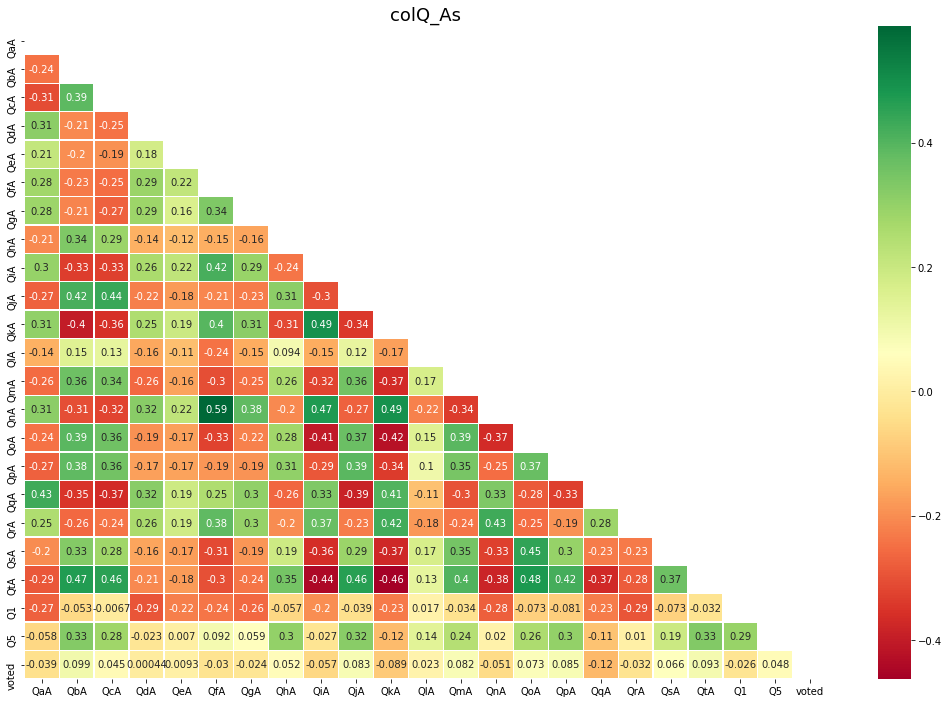

In [9]:
colQ_As = Q_A.tolist()
colQ_As.extend(['Q1','Q5', 'voted'])

corr_Q_A = train[colQ_As].corr()

mask = np.zeros_like(corr_Q_A, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('colQ_As', fontsize=18)

sns.heatmap(corr_Q_A, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [10]:
corr_Q_A['voted'].abs().sort_values(ascending=False)

voted    1.000000
QqA      0.123306
QbA      0.099209
QtA      0.092549
QkA      0.089467
QpA      0.085131
QjA      0.083216
QmA      0.081733
QoA      0.072746
QsA      0.066020
QiA      0.057056
QhA      0.051604
QnA      0.050793
Q5       0.048015
QcA      0.045148
QaA      0.038820
QrA      0.031723
QfA      0.030309
Q1       0.025671
QgA      0.023765
QlA      0.023158
QeA      0.009300
QdA      0.000442
Name: voted, dtype: float64

### Q_E

In [11]:
Q_E = meta[meta.gbn == 'Q_E'].index
train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


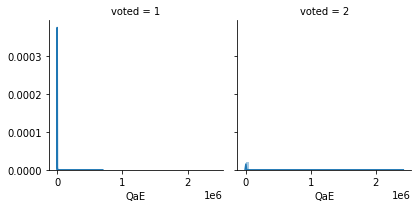

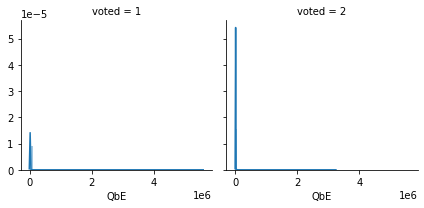

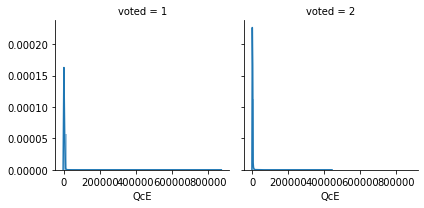

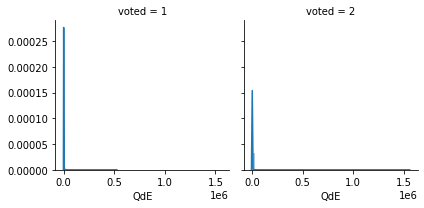

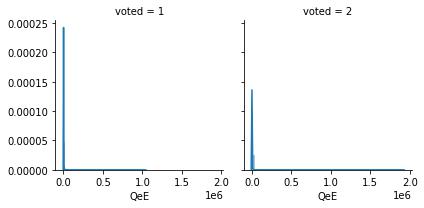

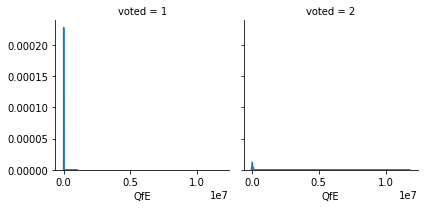

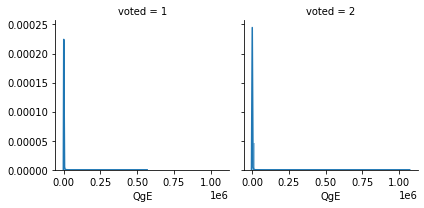

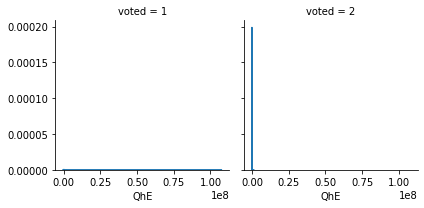

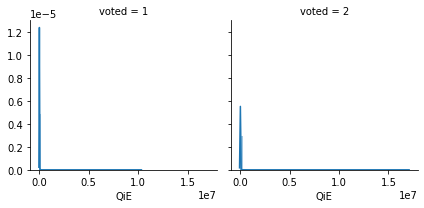

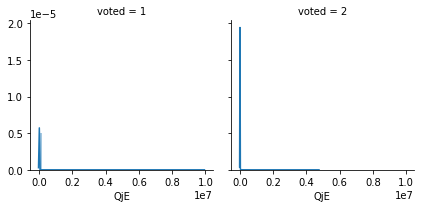

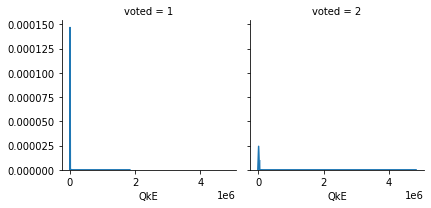

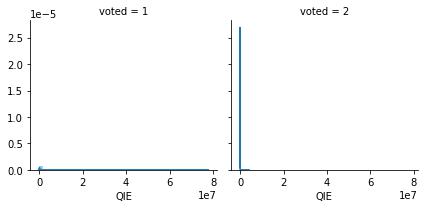

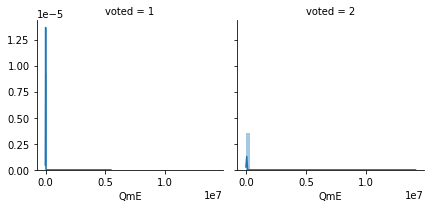

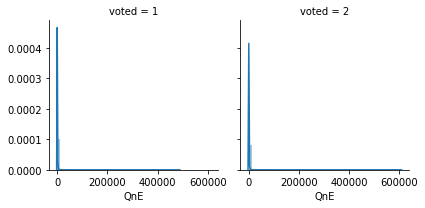

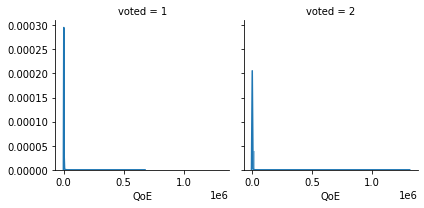

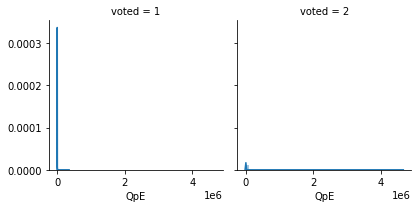

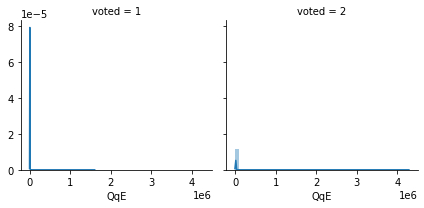

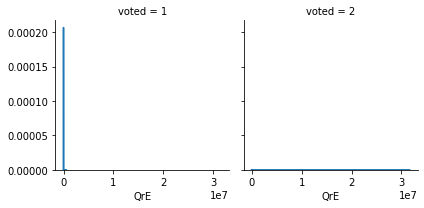

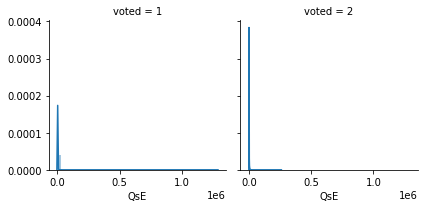

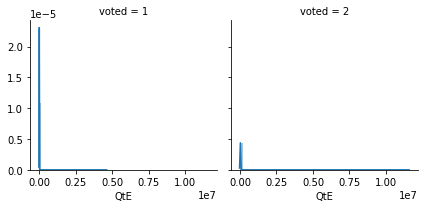

In [12]:
for f in Q_E:
    g = sns.FacetGrid(train, col='voted').map(sns.distplot, f)

In [20]:
for f in Q_E:
    print(f, train[f].min(), train[f].max())

QaE 3.258096538021482 14.69677952475103
QbE 3.258096538021482 15.534770299581337
QcE 3.258096538021482 13.678037693649705
QdE 3.295836866004329 14.255584478691235
QeE 3.258096538021482 14.467797722447822
QfE 3.258096538021482 16.280529246815284
QgE 3.258096538021482 13.88153516183371
QhE 0.0 18.4891429386553
QiE 0.0 16.650831150799657
QjE 0.0 16.109055612663138
QkE 0.0 15.38931175903102
QlE 3.258096538021482 18.166349781933498
QmE 3.258096538021482 16.462275323127148
QnE 3.258096538021482 13.315781472591008
QoE 0.0 14.085339202196463
QpE 0.0 15.35253754974552
QqE 0.0 15.268881856340737
QrE 3.258096538021482 17.268455155975815
QsE 3.258096538021482 14.067499647498977
QtE 3.258096538021482 16.262759039855734


<Figure size 1296x864 with 0 Axes>

Text(0.5, 1.0, 'colQ_ES')

<AxesSubplot:title={'center':'colQ_ES'}>

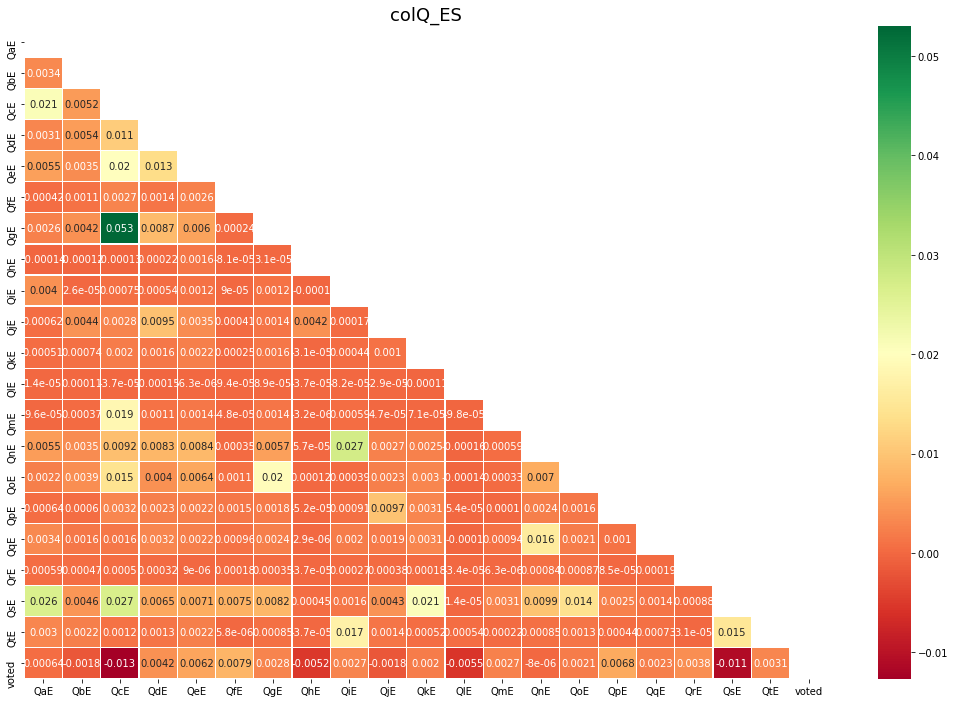

In [14]:
colQ_Es = Q_E.tolist()
colQ_Es.extend(['voted'])

corr_Q_E = train[colQ_Es].corr()

mask = np.zeros_like(corr_Q_E, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('colQ_ES', fontsize=18)

sns.heatmap(corr_Q_E, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

#### skew

In [19]:
for f in Q_E:
    train[f] = np.log1p(train[f])
    test[f] = np.log1p(test[f])

### tp

In [ ]:
# 0~7 
tp = meta[meta.gbn=='tp'].index
train[tp].describe()
train[tp].head(3)

In [ ]:
col_tps = tp.tolist()
col_tps.extend(['voted'])

corr_tp = train[col_tps].corr()

mask = np.zeros_like(corr_tp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('col_tpS', fontsize=18)

sns.heatmap(corr_tp, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [ ]:
meta.gbn.unique()

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

In [ ]:
corr = train.corr()
corr['voted'].abs().sort_values(ascending=False)[:20]
corr['voted'].abs().sort_values(ascending=False)[60:]

## Target Encoding

### age_group

In [22]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [23]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [24]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [25]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [26]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [27]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [ ]:
test.familysize.max(), test.familysize.mean(), train[train.familysize < 30]['familysize'].mean()

In [ ]:
train[train.familysize > 20][['voted', 'familysize']]

In [28]:
train.loc[train[train.familysize > 25].index, 'familysize'] = 2.6

In [ ]:
train['familysize'].value_counts()

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

#test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [ ]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

In [ ]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

In [ ]:
train.shape, test.shape
train.columns.values
test.columns.values

# 3. 모델 학습

In [29]:
from pycaret.classification import *

In [30]:
import gc
gc.collect()

32

In [31]:
col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat

['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
 'race',
 'religion',
 'urban']

In [32]:
col_numeric = ['Q1','Q5']
col_numeric

['Q1', 'Q5']

In [ ]:
#col_ignore = meta[(meta.gbn == 'wf') | (meta.gbn == 'wr')].index.values.tolist()
#col_ignore = meta[(meta.gbn == 'Q_E')].index.values.tolist()
col_ignore = []

In [41]:
%%time
clf = setup(session_id=42, 
            data = train, target = 'voted', polynomial_features=True
          , categorical_features=col_cat
            ,numeric_features=col_numeric
            #,ignore_features =col_ignore
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 80)"
4,Missing Values,False
5,Numeric Features,23
6,Categorical Features,56
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 23.8 s


In [34]:
#best_3 = compare_models(sort = 'AUC', n_select = 3)
best_5 = compare_models(sort = 'AUC', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6954,0.7643,0.6347,0.7680,0.6950,0.3963,0.4036,38.3977
1,CatBoost Classifier,0.6949,0.7633,0.6517,0.7565,0.7001,0.3931,0.3977,23.9066
2,Light Gradient Boosting Machine,0.6937,0.7632,0.6390,0.7623,0.6951,0.3921,0.3984,1.4773
3,Linear Discriminant Analysis,0.6927,0.7602,0.6587,0.7491,0.7009,0.3876,0.3911,1.7562
4,Extra Trees Classifier,0.6921,0.7585,0.6304,0.7652,0.6912,0.3899,0.3972,5.5860
5,Logistic Regression,0.6893,0.7560,0.6499,0.7487,0.6957,0.3815,0.3855,1.6510
6,Ada Boost Classifier,0.6916,0.7545,0.6497,0.7525,0.6973,0.3865,0.3909,9.8201
7,Extreme Gradient Boosting,0.6760,0.7451,0.6634,0.7216,0.6912,0.3517,0.3531,19.4875
8,Naive Bayes,0.6572,0.7211,0.5529,0.7567,0.6371,0.3269,0.3426,0.2735
9,Random Forest Classifier,0.6583,0.7135,0.6040,0.7252,0.6590,0.3223,0.3278,0.6586


In [35]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6993,0.7716,0.6426,0.7695,0.7003,0.4034,0.4101
1,0.7007,0.7719,0.6509,0.7666,0.7040,0.4054,0.4109
2,0.6887,0.7579,0.6354,0.7565,0.6907,0.3822,0.3881
3,0.7052,0.7735,0.6597,0.7684,0.7099,0.4138,0.4188
4,0.6881,0.7615,0.6396,0.7528,0.6916,0.3803,0.3855
Mean,0.6964,0.7673,0.6456,0.7627,0.6993,0.3970,0.4027
SD,0.0068,0.0063,0.0087,0.0068,0.0073,0.0133,0.0133


In [36]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6951,0.7699,0.6416,0.7631,0.6971,0.3947,0.4008


In [37]:
final_model = finalize_model(blended)

In [38]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [39]:
submission['voted'] = predictions['Score']

# 5. 제출

In [40]:
submission.to_csv('output/20200930-2.csv')